## Projet 7 : Implémenter un modèle de scoring


Ce notebook présente la démarche complète pour la réalisation d'un modèle de scoring de crédit, dans le cadre de l'entreprise "Prêt à dépenser", spécialisée dans l'octroi de crédits à la consommation pour des clients avec peu ou pas d'historique de prêt. L'objectif principal est de développer un algorithme de classification capable de prédire la probabilité de défaut d'un client sur son crédit. Cette prédiction permettra de classer automatiquement les demandes de crédit en deux catégories : crédit accordé ou crédit refusé.

Pour atteindre cet objectif, nous allons suivre une approche structurée en plusieurs étapes :

- Analyse exploratoire des données : Explorer et comprendre les données disponibles, en analysant leur distribution, les corrélations entre les variables, et en identifiant les éventuels déséquilibres dans les classes.
- Préparation des données et Feature Engineering : Traiter et transformer les données pour les rendre compatibles avec les algorithmes de machine learning, en sélectionnant les features les plus pertinentes pour la prédiction.
- Développement du modèle de scoring : Entraîner et optimiser un modèle de classification pour prédire la probabilité de défaut des clients, tout en tenant compte des spécificités du métier, notamment le déséquilibre entre les classes et le coût des erreurs de classification.
- Interprétation du modèle : Analyser les features les plus importantes globalement et localement pour fournir des explications claires sur les décisions prises par le modèle.
- Mise en production : Déployer le modèle via une API et réaliser une interface de test, tout en suivant une démarche MLOps pour garantir l'automatisation et l'industrialisation du cycle de vie du modèle.

# PARTIE 1 : Préparation

## <a name="C4"> Mise en place de l'environnement de travail</a>

- Importation des librairies

In [22]:
import sys
import pprint
import os
import time
import re
import numpy as np
import pandas as pd
import matplotlib as pl
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import category_encoders as ce
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PolynomialFeatures
import preprocessing as LD0
import mlflow                                                   
from mlflow.models import infer_signature  
from mlflow.data import from_pandas             
from mlflow.client import MlflowClient           
import imblearn                                                       
from imblearn.under_sampling import RandomUnderSampler           
from imblearn.over_sampling import RandomOverSampler           
from imblearn.over_sampling import SMOTE                       
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer                 
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split            
from sklearn.model_selection import GridSearchCV                 
import lightgbm as lgbm
from sklearn.svm import LinearSVC              
from lightgbm import LGBMClassifier               
from sklearn.ensemble import RandomForestClassifier       
from sklearn.linear_model import LogisticRegression       
from sklearn.pipeline import make_pipeline
import shap
import evidently
from evidently import ColumnMapping
from evidently.report import Report
from evidently.metric_preset import DataDriftPreset


- Versions des librairies

In [23]:
import pkg_resources

libraries = [
    'pandas',
    'lightgbm',
    'streamlit',
    'matplotlib',
    'requests',
    'scikit-learn',
    'flask',
    'plost',
    'Image', 
    'shap',
    'NumpyEncoder',  
    'streamlit_shap'
]

for lib in libraries:
    try:
        version = pkg_resources.get_distribution(lib).version
        print(f"{lib}: {version}")
    except pkg_resources.DistributionNotFound:
        print(f"{lib} est introuvable dans l'environnement virtuel")


pandas: 1.5.3
lightgbm: 4.1.0
streamlit: 1.29.0
matplotlib: 3.6.0
requests: 2.32.3
scikit-learn: 1.5.2
flask: 3.0.3
plost: 0.2.5
Image: 1.5.33
shap: 0.46.0
NumpyEncoder: 0.3.0
streamlit_shap: 1.0.2


- Règles d'affichage

In [24]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', None)  
pd.set_option('display.max_rows', None)   
pd.set_option('display.max_colwidth', 40) 
pd.set_option('display.float_format', lambda x: '%.3f' % x)

- Chemins de sauvegarde

In [25]:
ZIP_TEST_DATA_FILENAME = "data/test_data.zip"              
DRIFT_FILENAME = "data_drift.html"    
MLFLOW_MODEL_FOLDER = "data/mlflow_model"                 
MLFLOW_MODEL_FOLDER_WIN = "data\\mlflow_model"

- Création des fonctions utiles

In [26]:
# Lecture et prétraitement CSV 
def read_csv(filename):
    try:data_df = pd.read_csv("data/"+filename,sep = ',',encoding = 'utf-8',)
    except Exception:data_df = pd.read_csv("data/"+filename,sep = ',',encoding = 'iso-8859-1')

    # valeurs infinies 
    nbr_inf = data_df[data_df == np.inf].count().sum()
    if nbr_inf>0:
        print("Valeurs infinies remplacées par 0 : {nbr_inf}")
        data_df = data_df.replace(np.inf, 0)

    # doublons 
    nbr_doublons = data_df.duplicated().sum()
    if (nbr_doublons>0):
        print("Lignes contenant doublons supprimées : {nbr_doublons}")
        data_df.drop_duplicates(inplace=True)
    
    # taux remplissage
    colonnes = data_df.columns
    lignes_avec_nan = data_df.isna().any(axis=1)
    taux_remplissage = [1-(data_df[col].isnull().sum()/data_df.shape[0]) for col in colonnes]
    if min(taux_remplissage)<1.0:
        print(f"\tTaux de remplissage moyen de {np.mean(taux_remplissage)*100:.2f}%, de {colonnes[taux_remplissage.index(max(taux_remplissage))]} ({max(taux_remplissage)*100:.2f}%) à {colonnes[taux_remplissage.index(min(taux_remplissage))]} ({min(taux_remplissage)*100:.2f}%)")
    else :
        print(f"\tTaux de remplissage de 100%")
    print(f"\tLe fichier {filename} contient {data_df.shape[0]} lignes et {data_df.shape[1]} colonnes.")
    return data_df

In [27]:
# distribution
def distribution(df, variable):
    figure = plt.figure(figsize = (8, 2))
    ax1 = plt.subplot2grid(shape=(1, 2), loc=(0, 0), colspan=1, rowspan=1)
    ax2 = plt.subplot2grid(shape=(1, 2), loc=(0, 1), colspan=1, rowspan=1)
    ax1.hist(df[variable], bins=50, histtype='stepfilled', color='maroon')

    df[[variable]].boxplot(ax=ax2, column=variable, vert=False, notch=False, patch_artist=True)
    plt.suptitle('')
    ax2.tick_params(axis='y', which='both', labelleft=False, labelright=False)
    ax1.set_title(f"Distribution de la variable {variable}", fontsize=8, color='darkred')
    ax2.set_title(f"Boxplot de la variable {variable}",      fontsize=8, color='darkred')

    plt.show()

In [28]:
# missingno
def filling_rate(df):
    if df.shape[1]<50:
        largeur = (12/9)*len(df.columns)
        msno.bar(df, log=False, figsize=(largeur,4), fontsize=8, label_rotation=45, sort="ascending")
    else:
        hauteur = (12/9)*len(df.columns)
        msno.bar(df, log=False, figsize=(4,hauteur), fontsize=8, label_rotation=0, sort="ascending")
    plt.xticks(fontsize=8, rotation=90)
    plt.yticks(fontsize=8, rotation=0)
    plt.show()

In [29]:
# outliers
def outliers(df, variable, facteur):
    q1 = df[variable].quantile(.25)
    q3 = df[variable].quantile(.75)
    IQR = q3 - q1
    lower = q1 - (facteur*IQR) 
    upper = q3 + (facteur*IQR)
    min_column = df[variable].min()
    max_column = df[variable].max()
    if lower < min_column:
        lower = min_column
    if upper > max_column:
        upper = max_column
    return lower, upper

In [30]:
def outliers_analyse(df, variable, facteur):
    distribution(df, variable)
    print(df[variable].describe(include='all'))
    print("\n")
    print(df[variable].info(show_counts=True))
    lower, upper = outliers(df, variable, facteur)
    nbr_lower = df[df[variable]<lower].shape[0] 
    nbr_upper = df[df[variable]>upper].shape[0] 
    print(f"\n{nbr_lower} valeurs sont <{lower} et {nbr_upper} sont >{upper} pour {facteur} fois l'IQR")

## <a name="C4"> Analyse exploratoire</a>

- Structure des données

![image](https://storage.googleapis.com/kaggle-media/competitions/home-credit/home_credit.png)

- Premier nettoyage des données

- remplace les valeurs infinies par 0
- supprime les doublons
- Supprime les individus pour lesquels le SK_ID_CURR, SK_ID_BUREAU et SK_ID_PREV n'existe pas


In [31]:
def delete_useless(df, var_id, list_id, nom_df, nom_liste):
    anc_nbr_lignes = df.shape[0]
    df.drop(df[~df[var_id].isin(list_id)].index, inplace=True)
    print(f"\t\t{nom_df} contient {df.shape[0]} au lieu de {anc_nbr_lignes} lignes soit {df.shape[0]-anc_nbr_lignes} lignes")

app_train_df = read_csv("input/application_train.csv")
bureau_df = read_csv("input/bureau.csv")
delete_useless(bureau_df, 'SK_ID_CURR', app_train_df['SK_ID_CURR'].tolist(), "bureau.csv", "application_train.csv")
bureau_balance_df = read_csv("input/bureau_balance.csv")
delete_useless(bureau_balance_df, 'SK_ID_BUREAU', bureau_df['SK_ID_BUREAU'].tolist(), "bureau_balance.csv", "bureau.csv")
previous_application_df = read_csv("input/previous_application.csv")
delete_useless(previous_application_df, 'SK_ID_CURR', app_train_df['SK_ID_CURR'].tolist(), "previous_application.csv", "application_train.csv")
POS_CASH_balance_df = read_csv("input/POS_CASH_balance.csv")
delete_useless(POS_CASH_balance_df, 'SK_ID_CURR', app_train_df['SK_ID_CURR'].tolist(), "POS_CASH_balance.csv", "application_train.csv")
delete_useless(POS_CASH_balance_df, 'SK_ID_PREV', previous_application_df['SK_ID_PREV'].tolist(), "POS_CASH_balance.csv", "previous_application.csv")
credit_card_balance_df = read_csv("input/credit_card_balance.csv")
delete_useless(credit_card_balance_df, 'SK_ID_PREV', previous_application_df['SK_ID_PREV'].tolist(), "credit_card_balance.csv", "previous_application.csv")
del previous_application_df

	Taux de remplissage moyen de 75.60%, de SK_ID_CURR (100.00%) à COMMONAREA_AVG (30.13%)
	Le fichier input/application_train.csv contient 307511 lignes et 122 colonnes.
	Taux de remplissage moyen de 86.50%, de SK_ID_CURR (100.00%) à AMT_ANNUITY (28.53%)
	Le fichier input/bureau.csv contient 1716428 lignes et 17 colonnes.
		bureau.csv contient 1465325 au lieu de 1716428 lignes soit -251103 lignes
	Taux de remplissage de 100%
	Le fichier input/bureau_balance.csv contient 27299925 lignes et 3 colonnes.
		bureau_balance.csv contient 14701612 au lieu de 27299925 lignes soit -12598313 lignes
	Taux de remplissage moyen de 82.02%, de SK_ID_PREV (100.00%) à RATE_INTEREST_PRIMARY (0.36%)
	Le fichier input/previous_application.csv contient 1670214 lignes et 37 colonnes.
		previous_application.csv contient 1413701 au lieu de 1670214 lignes soit -256513 lignes
	Taux de remplissage moyen de 99.93%, de SK_ID_PREV (100.00%) à CNT_INSTALMENT_FUTURE (99.74%)
	Le fichier input/POS_CASH_balance.csv contien

## <a name="C4"> Utilisation Kernel Kaggle</a>

- bureau_balance.csv

14,7M de lignes -> 500 000 lignes  
- Si DPD > 1 = retard de remboursement
- OneHotEncoder de la variable STATUS
- Groupe les données par SK_ID_BUREAU
- Ajouter les valeurs des colonnes status
- Agréger la colonne MONTHS_BALANCE pour ne garder que la valeur min
- Remplacer toutes les colonnes de status par une colonne incident
- Remplacer la colonne STATUS par un binary indiquant s'il y a eut problème de paiement
- Agréger la valeur max dans la colonne MONTHS_BALANCE

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


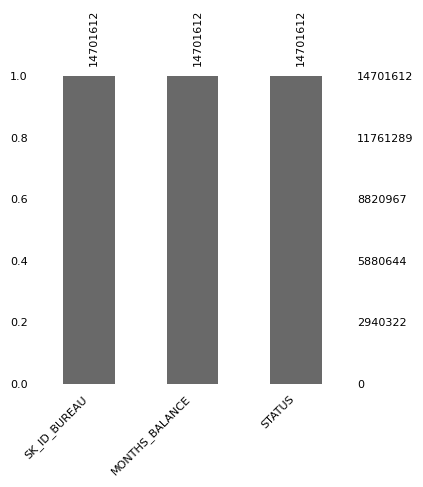

Le fichier contient 523515 lignes et 3 colonnes.


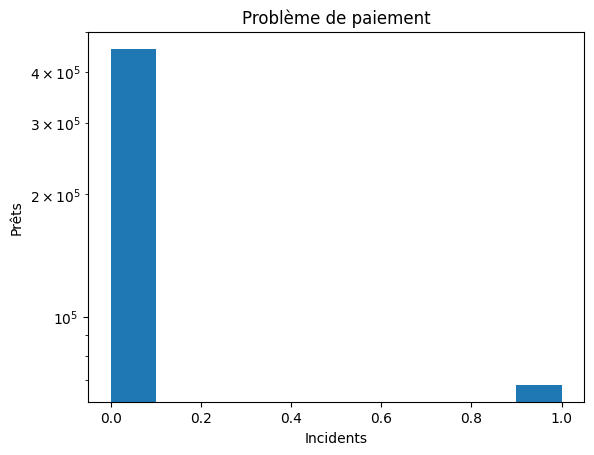

In [32]:
display(bureau_balance_df.head())
filling_rate(bureau_balance_df)

# One hot encoder
encoder = ce.OneHotEncoder(cols=['STATUS'], use_cat_names=True)   
bureau_balance_df = encoder.fit_transform(bureau_balance_df)               
col = encoder.get_feature_names_out()[2:]                         
dict_agg = {col[i]: 'sum' for i in range(0, len(col))}                    
dict_agg['MONTHS_BALANCE']='min'                                          

bureau_balance_df = bureau_balance_df.groupby('SK_ID_BUREAU', as_index=False).agg(dict_agg) 
bureau_balance_df = bureau_balance_df.reset_index(drop=True)               
bureau_balance_df['INCIDENTS']=bureau_balance_df['STATUS_1']+bureau_balance_df['STATUS_2']+bureau_balance_df['STATUS_3']+bureau_balance_df['STATUS_4']+bureau_balance_df['STATUS_5']
bureau_balance_df.loc[bureau_balance_df['INCIDENTS']>0, 'INCIDENTS']=1 
bureau_balance_df=bureau_balance_df[['SK_ID_BUREAU', 'MONTHS_BALANCE', 'INCIDENTS']]

print(f"Le fichier contient {bureau_balance_df.shape[0]} lignes et {bureau_balance_df.shape[1]} colonnes.")

# incidents de paiements
ax1 = bureau_balance_df['INCIDENTS'].astype(int).plot(kind='hist', logy=True);
ax1.set_title("Problème de paiement");
ax1.set_ylabel("Prêts");
ax1.set_xlabel("Incidents");

- bureau.csv

1,7M de lignes -> 263280 lignes
- Supprime AMT_ANNUITY et AMT_CREDIT_MAX_OVERDUE trop de NaN
- Remplace par 0
- Fusionne avec bureau_balance.csv par SK_BUREAU_ID
- Supprime la colonne SK_BUREAU_ID
- Remplace les NaN INCIDENTS par des 0
- Remplace les NaN MONTHS_BALANCE par la médiane 
- Supprime les crédits qui ne sont pas dans la monnaie currency 1 et supprime la colonne 
- Compte le nombre de crédits clos et le nombre de crédit clos pour lesquels au moins un incident de paiemment est survennus
- Compte le nombre de crédits actif et le nombre de crédit actif pour lesquels au moins un incident de paiemment est survennus
- Agréger les informations restantes pour les crédits encore actifs

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.000,-153.000,NaN,0,91323.000,0.000,NaN,0.000,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.000,NaN,NaN,0,225000.000,171342.000,NaN,0.000,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.000,NaN,NaN,0,464323.500,NaN,NaN,0.000,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.000,NaN,NaN,0.000,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.000,NaN,77674.500,0,2700000.000,NaN,NaN,0.000,Consumer credit,-21,NaN


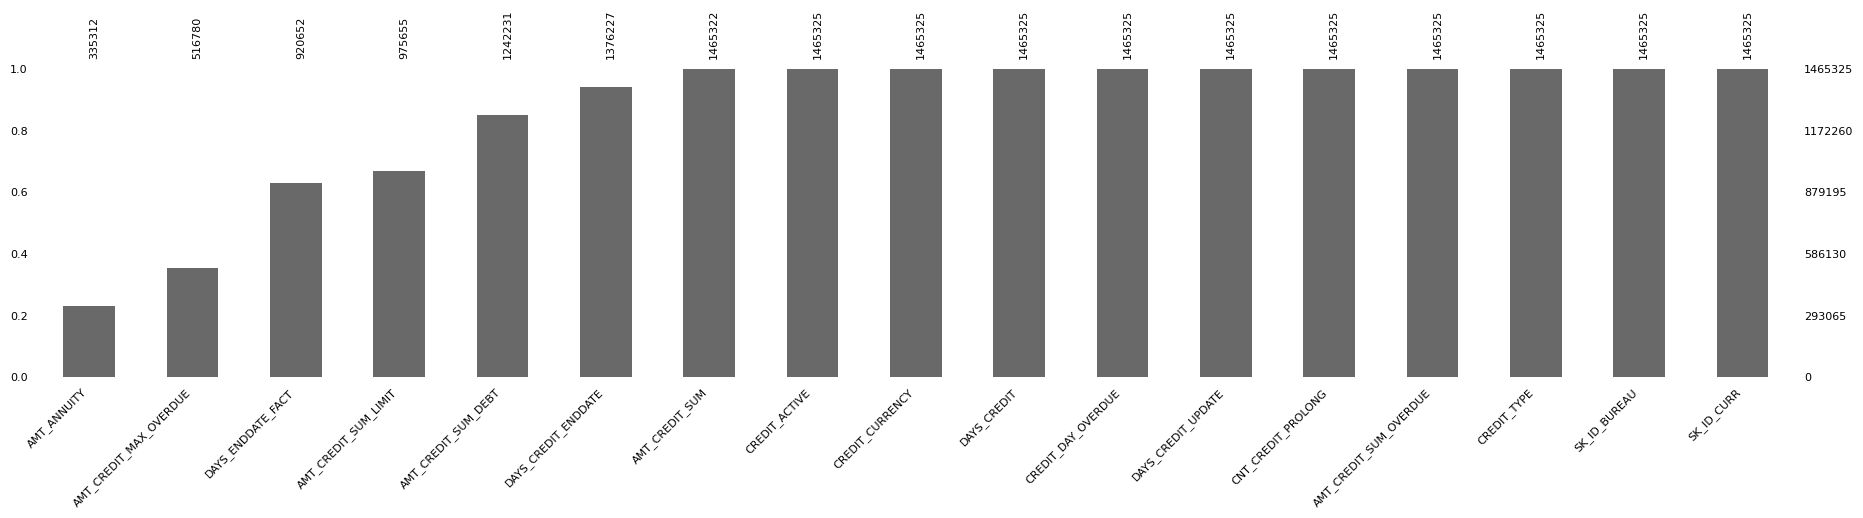

bureau_df contient 1465325 lignes et 16 colonnes.


,SK_ID_CURR,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,MONTHS_BALANCE,INCIDENTS
0,215354,Closed,currency 1,-497,0,-153.000,-153.000,0,91323.000,0.000,0.000,0.000,Consumer credit,-131,-31.000,0.000
1,215354,Active,currency 1,-208,0,1075.000,0.000,0,225000.000,171342.000,0.000,0.000,Credit card,-20,-31.000,0.000
2,215354,Active,currency 1,-203,0,528.000,0.000,0,464323.500,0.000,0.000,0.000,Consumer credit,-16,-31.000,0.000
3,215354,Active,currency 1,-203,0,0.000,0.000,0,90000.000,0.000,0.000,0.000,Credit card,-16,-31.000,0.000
4,215354,Active,currency 1,-629,0,1197.000,0.000,0,2700000.000,0.000,0.000,0.000,Consumer credit,-21,-31.000,0.000


In [33]:
display(bureau_df.head())
filling_rate(bureau_df)

del(bureau_df['AMT_ANNUITY'])
del(bureau_df['AMT_CREDIT_MAX_OVERDUE'])
bureau_df.replace(np.nan, 0, inplace=True)
bureau_df = pd.merge(bureau_df, bureau_balance_df, left_on="SK_ID_BUREAU", right_on="SK_ID_BUREAU", how="outer")
del(bureau_df['SK_ID_BUREAU'])
MEDIAN_MONTHS_BALANCE = np.median(bureau_balance_df['MONTHS_BALANCE'])
del(bureau_balance_df)
bureau_df.loc[bureau_df['INCIDENTS'].isnull(), 'INCIDENTS']=0 
bureau_df.loc[bureau_df['MONTHS_BALANCE'].isnull(), 'MONTHS_BALANCE']=MEDIAN_MONTHS_BALANCE

print(f"bureau_df contient {bureau_df.shape[0]} lignes et {bureau_df.shape[1]} colonnes.")
display(bureau_df.head())

- currency


- Suppression des currency autres que currency_1 ainsi que de ladite colonne

In [34]:
anc_nbr_lignes = bureau_df.shape[0]
bureau_df.drop(bureau_df[bureau_df['CREDIT_CURRENCY'].isin(['currency 2', 'currency 3', 'currency 4'])].index, inplace=True)
print(f"bureau_df contient {bureau_df.shape[0]} lignes au lieu de {anc_nbr_lignes} lignes")
del(bureau_df['CREDIT_CURRENCY'])

bureau_df contient 1464094 lignes au lieu de 1465325 lignes


- Incidents de paiement


- Dénombrer les crédits clos et actifs

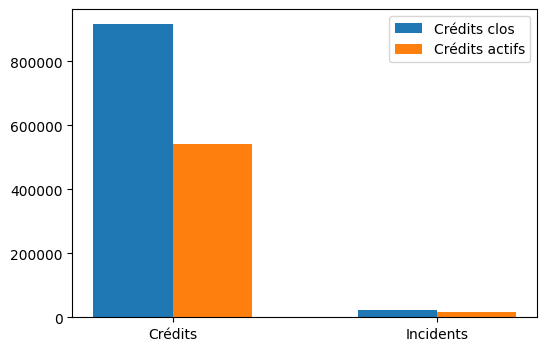

In [35]:
bureau_clos_df = bureau_df[bureau_df['CREDIT_ACTIVE']=='Closed'].groupby('SK_ID_CURR', as_index=False).agg(CREDITS_CLOS=('SK_ID_CURR', 'count'), INCIDENTS_CREDITS_CLOS=('INCIDENTS', 'max')).reset_index(drop=True)
bureau_actifs_df = bureau_df[bureau_df['CREDIT_ACTIVE']=='Active'].groupby('SK_ID_CURR', as_index=False).agg(CREDITS_ACTIFS=('SK_ID_CURR', 'count'), INCIDENTS_CREDITS_ACTIFS=('INCIDENTS', 'max')).reset_index(drop=True)

bureau_incidents_df = pd.merge(bureau_clos_df, bureau_actifs_df, left_on="SK_ID_CURR", right_on="SK_ID_CURR", how="outer")

del(bureau_clos_df)
del(bureau_actifs_df)

for col in ['CREDITS_CLOS', 'INCIDENTS_CREDITS_CLOS', 'CREDITS_ACTIFS', 'INCIDENTS_CREDITS_ACTIFS']:
    bureau_incidents_df.loc[bureau_incidents_df[col].isnull(), col]=0

plt.figure(figsize = (6, 4))

Nbr_CREDITS_CLOS = bureau_incidents_df['CREDITS_CLOS'].sum()
Nbr_INCIDENTS_CREDITS_CLOS = bureau_incidents_df['INCIDENTS_CREDITS_CLOS'].sum()
Nbr_CREDITS_ACTIFS = bureau_incidents_df['CREDITS_ACTIFS'].sum()
Nbr_INCIDENTS_CREDITS_ACTIFS = bureau_incidents_df['INCIDENTS_CREDITS_ACTIFS'].sum()

plt.bar([0.0, 1.0], [Nbr_CREDITS_CLOS, Nbr_INCIDENTS_CREDITS_CLOS], width=0.3, label="Crédits clos")
plt.bar([0.3, 1.3], [Nbr_CREDITS_ACTIFS, Nbr_INCIDENTS_CREDITS_ACTIFS], width=0.3, label="Crédits actifs")
plt.xticks([r+0.15 for r in range(2)], ['Crédits', "Incidents"])
plt.legend()
plt.show()

- Supprimer les crédits clos
- Grouper par SK_ID_CURR

In [36]:
anc_nbr_lignes = bureau_df.shape[0]
bureau_df.drop(bureau_df[bureau_df['CREDIT_ACTIVE']=='Closed'].index, inplace=True)
print("bureau_df contient {bureau_df.shape[0]} lignes au lieu de {anc_nbr_lignes} lignes")

aggregations = {
    'DAYS_CREDIT' : 'median',                     
    'DAYS_CREDIT_ENDDATE' : 'median',                    
    'DAYS_CREDIT_UPDATE' : 'median',                  
    'CREDIT_DAY_OVERDUE' : 'median',                   
    'DAYS_ENDDATE_FACT' : 'median',                    
    'AMT_CREDIT_SUM' : 'sum',                       
    'AMT_CREDIT_SUM_DEBT' : 'sum',                       
    'AMT_CREDIT_SUM_OVERDUE': 'sum',                       
    'AMT_CREDIT_SUM_LIMIT' : 'max',                     
    'CNT_CREDIT_PROLONG' : 'sum',                       
    'MONTHS_BALANCE' : 'median',                     
}
anc_nbr_lignes = bureau_df.shape[0]
bureau_num_df = bureau_df[bureau_df['CREDIT_ACTIVE']=='Active'].groupby('SK_ID_CURR', as_index=False).agg(aggregations) 
bureau_num_df = bureau_num_df.reset_index(drop=True)        
bureau_df = pd.merge(bureau_num_df, bureau_incidents_df, left_on="SK_ID_CURR", right_on="SK_ID_CURR", how="outer")
del(bureau_num_df)
del(bureau_incidents_df)

for col in bureau_df.columns:
    bureau_df.loc[bureau_df[col].isnull(), col]=0
bureau_df.rename(columns={'CREDITS_CLOS': 'CREDITS_CLOS'}, inplace=True)
bureau_df.rename(columns={'INCIDENTS_CREDITS_CLOS': 'INCIDENTS_CREDITS_CLOS'}, inplace=True)
bureau_df.rename(columns={'CREDITS_ACTIFS': 'B_CREDITS_ACTIFS'}, inplace=True)
bureau_df.rename(columns={'INCIDENTS_CREDITS_ACTIFS': 'B_INCIDENTS_CREDITS_ACTIFS'}, inplace=True)
bureau_df.rename(columns={'MONTHS_BALANCE': 'B_MONTHS_BALANCE'}, inplace=True)

print(f"bureau_df contient {bureau_df.shape[0]} lignes au lieu de {anc_nbr_lignes} lignes")

bureau_df contient {bureau_df.shape[0]} lignes au lieu de {anc_nbr_lignes} lignes
bureau_df contient 263280 lignes au lieu de 547415 lignes


- credit_car_balance.csv

3,8M de lignes -> 77934 lignes  
- Grouper par SK_ID_CURR
- compter le nombre d'incidents
- compter le nombre de crédit actifs

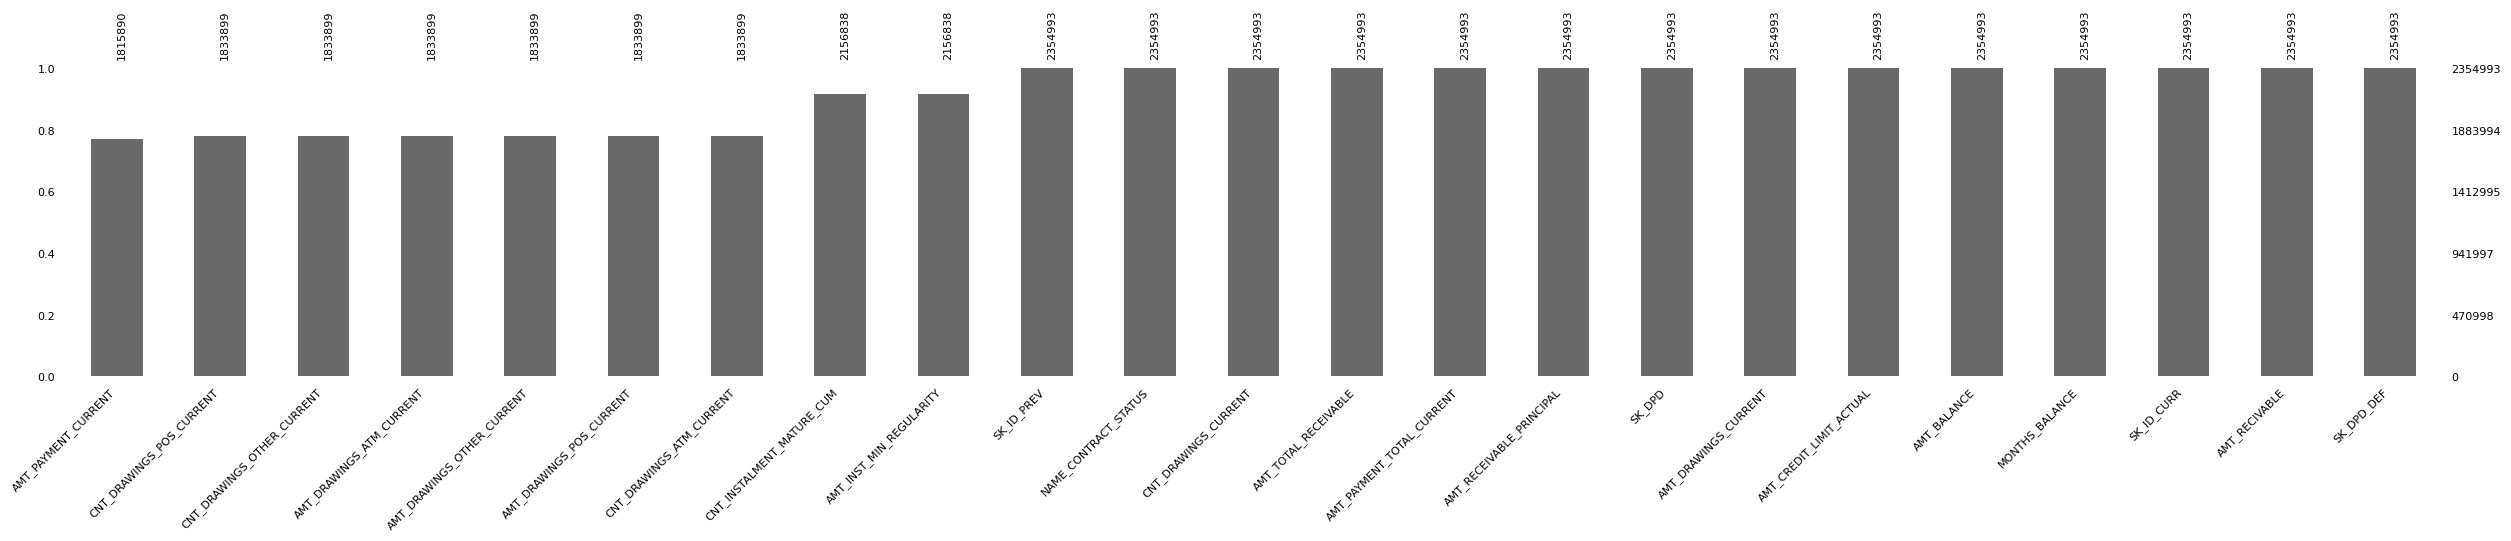

['Active' 'Completed' 'Signed' 'Sent proposal' 'Refused' 'Approved'
 'Demand']
credit_card_balance_df contient {credit_card_balance_df.shape[0]} lignes au lieu de {anc_nbr_lignes} lignes


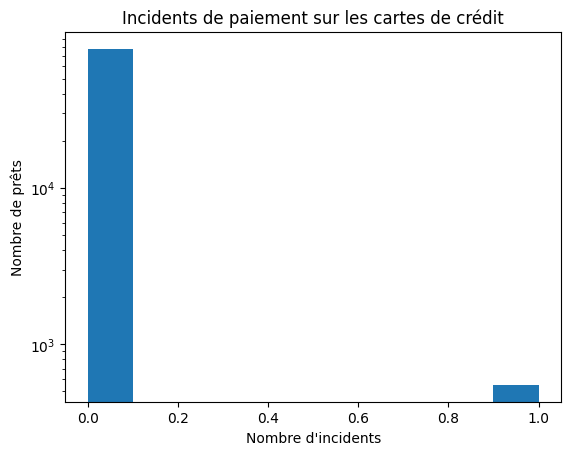

In [37]:
filling_rate(credit_card_balance_df)
print(credit_card_balance_df['NAME_CONTRACT_STATUS'].unique())
credit_card_balance_df.replace(np.nan, 0, inplace=True)
credit_card_balance_df.loc[credit_card_balance_df['SK_DPD']>0, 'SK_DPD'] = 1
credit_card_balance_df.loc[credit_card_balance_df['SK_DPD_DEF']>0, 'SK_DPD_DEF'] = 1

agg_data_cc_bal = {
    'SK_ID_PREV' : 'count',                     
    'MONTHS_BALANCE' : 'median',
    'AMT_BALANCE' : 'mean',
    'AMT_CREDIT_LIMIT_ACTUAL' : 'median',
    'AMT_DRAWINGS_ATM_CURRENT' : 'mean',
    'AMT_DRAWINGS_CURRENT' : 'mean',
    'AMT_DRAWINGS_OTHER_CURRENT' : 'mean',
    'AMT_DRAWINGS_POS_CURRENT' : 'mean',
    'AMT_INST_MIN_REGULARITY' : 'median',
    'AMT_PAYMENT_CURRENT' : 'median',
    'AMT_PAYMENT_TOTAL_CURRENT' : 'median',
    'AMT_RECEIVABLE_PRINCIPAL' : 'mean',
    'AMT_RECIVABLE' : 'mean',
    'AMT_TOTAL_RECEIVABLE' : 'median',
    'CNT_DRAWINGS_ATM_CURRENT' : 'sum',
    'CNT_DRAWINGS_CURRENT' : 'sum',
    'CNT_DRAWINGS_OTHER_CURRENT' : 'sum',
    'CNT_DRAWINGS_POS_CURRENT' : 'sum',
    'CNT_INSTALMENT_MATURE_CUM' : 'sum',
    'SK_DPD' : 'median',                    
    'SK_DPD_DEF' : 'median'                      
}

anc_nbr_lignes = credit_card_balance_df.shape[0]
credit_card_balance_df = credit_card_balance_df.groupby('SK_ID_CURR', as_index=False).agg(agg_data_cc_bal)
credit_card_balance_df = credit_card_balance_df.reset_index(drop=True)      
credit_card_balance_df['CCB_INCIDENTS_CREDITS_ACTIFS'] = credit_card_balance_df['SK_DPD'] + credit_card_balance_df['SK_DPD_DEF']
credit_card_balance_df.loc[credit_card_balance_df['CCB_INCIDENTS_CREDITS_ACTIFS']>0, 'CCB_INCIDENTS_CREDITS_ACTIFS'] = 1    # Passe en binaire oui/non
del(credit_card_balance_df['SK_DPD'])
del(credit_card_balance_df['SK_DPD_DEF'])
credit_card_balance_df.rename(columns={'SK_ID_PREV': 'CCB_CREDITS_ACTIFS'}, inplace=True)

print("credit_card_balance_df contient {credit_card_balance_df.shape[0]} lignes au lieu de {anc_nbr_lignes} lignes")

credit_card_balance_df.rename(columns={'MONTHS_BALANCE': 'CCB_MONTHS_BALANCE'}, inplace=True)
ax1 = credit_card_balance_df['CCB_INCIDENTS_CREDITS_ACTIFS'].astype(int).plot(kind='hist', logy=True);
ax1.set_title("Incidents de paiement sur les cartes de crédit");
ax1.set_ylabel("Nombre de prêts");
ax1.set_xlabel("Nombre d'incidents");

- POS_CASH_balance.csv

10M de lignes -> 286967  
- Groupe par SK_ID_CURR 
- compte le nombre d'incidents 
- compte le nombre de crédit actifs

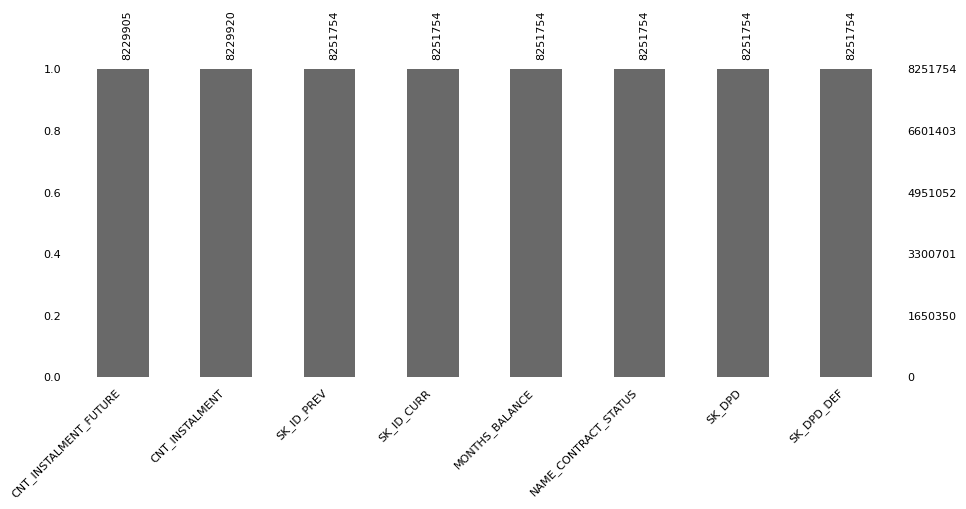

['Active' 'Signed' 'Completed' 'Approved' 'Returned to the store' 'Demand'
 'XNA' 'Canceled' 'Amortized debt']
POS_CASH_balance_df contient {POS_CASH_balance_df.shape[0]} lignes au lieu de {anc_nbr_lignes} lignes


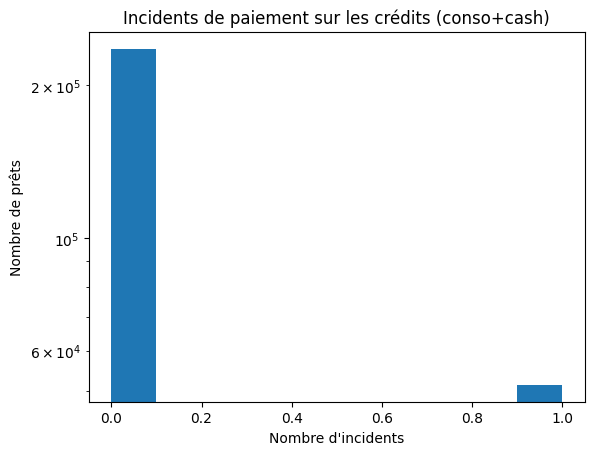

In [38]:
filling_rate(POS_CASH_balance_df)
print(POS_CASH_balance_df['NAME_CONTRACT_STATUS'].unique())
POS_CASH_balance_df.replace(np.nan, 0, inplace=True)
POS_CASH_balance_df.loc[POS_CASH_balance_df['SK_DPD']>0, 'SK_DPD'] = 1
POS_CASH_balance_df.loc[POS_CASH_balance_df['SK_DPD_DEF']>0, 'SK_DPD_DEF'] = 1
agg_data_pos_cash = {
    'SK_ID_PREV' : 'count',                             
    'MONTHS_BALANCE' : 'median',
    'CNT_INSTALMENT' : 'median',
    'CNT_INSTALMENT_FUTURE' : 'median',
    'SK_DPD' : 'sum',                              
    'SK_DPD_DEF' : 'sum'                               
}

anc_nbr_lignes = POS_CASH_balance_df.shape[0]
POS_CASH_balance_df = POS_CASH_balance_df.groupby('SK_ID_CURR', as_index=False).agg(agg_data_pos_cash)
POS_CASH_balance_df = POS_CASH_balance_df.reset_index(drop=True)     
POS_CASH_balance_df['PCB_INCIDENTS_CREDITS_ACTIFS'] = POS_CASH_balance_df['SK_DPD'] + POS_CASH_balance_df['SK_DPD_DEF']
POS_CASH_balance_df.loc[POS_CASH_balance_df['PCB_INCIDENTS_CREDITS_ACTIFS']>0, 'PCB_INCIDENTS_CREDITS_ACTIFS'] = 1    # Passe en binaire oui/non
del(POS_CASH_balance_df['SK_DPD'])
del(POS_CASH_balance_df['SK_DPD_DEF'])
POS_CASH_balance_df.rename(columns={'SK_ID_PREV': 'PCB_CREDITS_ACTIFS'}, inplace=True)
POS_CASH_balance_df.rename(columns={'MONTHS_BALANCE': 'PCB_MONTHS_BALANCE'}, inplace=True)

print("POS_CASH_balance_df contient {POS_CASH_balance_df.shape[0]} lignes au lieu de {anc_nbr_lignes} lignes")
ax1 = POS_CASH_balance_df['PCB_INCIDENTS_CREDITS_ACTIFS'].astype(int).plot(kind='hist', logy=True);
ax1.set_title("Incidents de paiement sur les crédits (conso+cash)");
ax1.set_ylabel("Nombre de prêts");
ax1.set_xlabel("Nombre d'incidents");

## <a name="C4"> Fusion des fichiers</a>

Fusionne ces 3 dataframe en un seul puis :
- Additionne les colonnes de credits actifs (une colonne par dataframe)
- Additionne les colonnes de nombre d'incident pour les credits actifs (une colonne par dataframe)
- Fait la medianne des colonnesMONTHS_BALANCE (une colonne par dataframe)

In [39]:
temp_df = pd.merge(bureau_df, credit_card_balance_df, left_on="SK_ID_CURR", right_on="SK_ID_CURR", how="outer")
temp_df = pd.merge(temp_df,   POS_CASH_balance_df,    left_on="SK_ID_CURR", right_on="SK_ID_CURR", how="outer")

temp_df['CREDITS_ACTIFS'] = temp_df['B_CREDITS_ACTIFS'] + temp_df['CCB_CREDITS_ACTIFS'] + temp_df['PCB_CREDITS_ACTIFS']
del(temp_df['B_CREDITS_ACTIFS'])
del(temp_df['CCB_CREDITS_ACTIFS'])
del(temp_df['PCB_CREDITS_ACTIFS'])

temp_df['INCIDENTS_CREDITS_ACTIFS'] = temp_df['B_INCIDENTS_CREDITS_ACTIFS'] + temp_df['CCB_INCIDENTS_CREDITS_ACTIFS'] + temp_df['PCB_INCIDENTS_CREDITS_ACTIFS']
temp_df.loc[temp_df['INCIDENTS_CREDITS_ACTIFS']>0, 'INCIDENTS_CREDITS_ACTIFS'] = 1  # Passe en binaire oui/non
del(temp_df['B_INCIDENTS_CREDITS_ACTIFS'])
del(temp_df['CCB_INCIDENTS_CREDITS_ACTIFS'])
del(temp_df['PCB_INCIDENTS_CREDITS_ACTIFS'])

temp_df['MONTHS_BALANCE'] = (temp_df['B_MONTHS_BALANCE'] + temp_df['CCB_MONTHS_BALANCE'] + temp_df['PCB_MONTHS_BALANCE'])/3
del(temp_df['B_MONTHS_BALANCE'])
del(temp_df['CCB_MONTHS_BALANCE'])
del(temp_df['PCB_MONTHS_BALANCE'])

temp_df.replace(np.nan, 0, inplace=True)

print("Le dataframe contient {temp_df.shape[0]} lignes et {temp_df.shape[1]} colonnes")

for col in temp_df.columns:
    if col != 'SK_ID_CURR':
        temp_df.rename(columns={col : "_SEC_" + col}, inplace=True)
app_train_df = pd.merge(app_train_df, temp_df, left_on="SK_ID_CURR", right_on="SK_ID_CURR", how="outer")

del bureau_df
del credit_card_balance_df
del POS_CASH_balance_df
del temp_df

Le dataframe contient {temp_df.shape[0]} lignes et {temp_df.shape[1]} colonnes


## <a name="C4"> Analyse application_train.csv</a>

- compte de la variable TARGET

0    282686
1     24825
Name: TARGET, dtype: int64


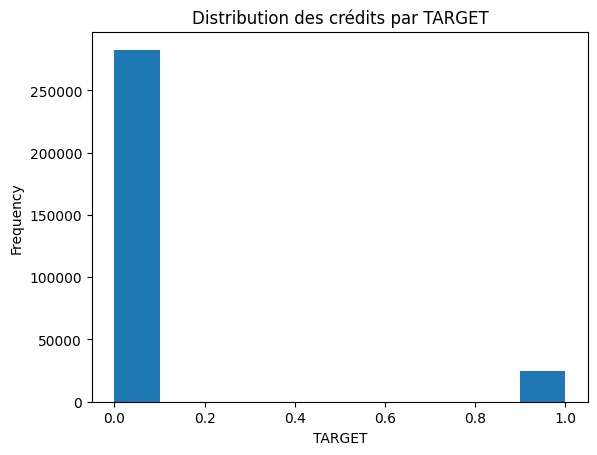

In [40]:
print(app_train_df['TARGET'].value_counts())
ax1 = app_train_df['TARGET'].astype(int).plot.hist();
ax1.set_title('Distribution des crédits par TARGET');
ax1.set_xlabel('TARGET');   


- Traitement des valeurs aberrantes

- Affiche l'age 

In [41]:
print((app_train_df['DAYS_BIRTH'] / -365).describe())


count   307511.000
mean        43.937
std         11.956
min         20.518
25%         34.008
50%         43.151
75%         53.923
max         69.121
Name: DAYS_BIRTH, dtype: float64


- affiche l'ancienneté en j au travail

count   307511.000
mean     63815.046
std     141275.767
min     -17912.000
25%      -2760.000
50%      -1213.000
75%       -289.000
max     365243.000
Name: DAYS_EMPLOYED, dtype: float64


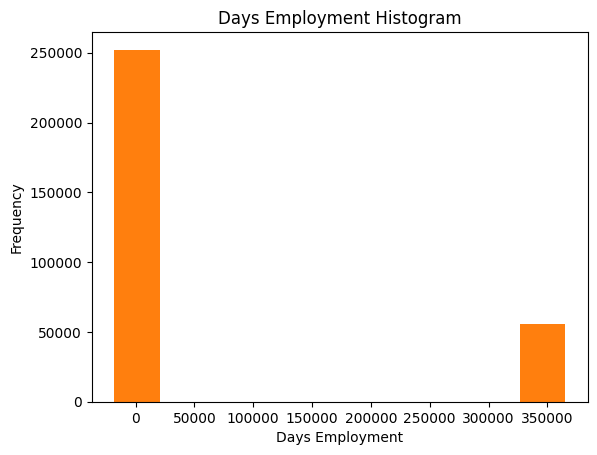

In [42]:
print(app_train_df['DAYS_EMPLOYED'].describe())
ax1 = app_train_df['DAYS_EMPLOYED'].plot.hist();
ax1.set_title('Days Employment Histogram');
ax1.set_xlabel('Days Employment');
ax1 = app_train_df['DAYS_EMPLOYED'].plot.hist();
ax1.set_title('Days Employment Histogram');
ax1.set_xlabel('Days Employment');

- valeur aberrante détéctée, nous remplaçons par la même valeur pour tous les outliers

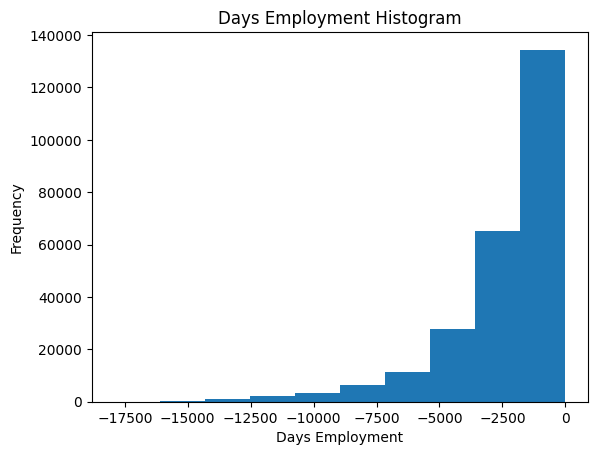

In [43]:
app_train_df['DAYS_EMPLOYED_ANOM'] = (app_train_df["DAYS_EMPLOYED"]==365243)
app_train_df['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace=True)
ax1 = app_train_df['DAYS_EMPLOYED'].plot.hist();
ax1.set_title('Days Employment Histogram');
ax1.set_xlabel('Days Employment');

- Corrélations

In [44]:
app_temp_df = app_train_df.copy()
print(app_temp_df.select_dtypes('object').apply(pd.Series.nunique, axis=0))
le = LabelEncoder()
le_count = 0

for col in app_temp_df.columns:
    if app_temp_df[col].dtype == 'object':
        # Si le nombre de catégories est <=2
        if len(list(app_temp_df[col].unique())) <= 2:
            # Fait la transformation
            print(f"\tTransforme la colonne {col}")
            app_temp_df[col] = le.fit_transform(app_temp_df[col])
            le_count += 1
            
app_temp_df = pd.get_dummies(app_temp_df)
print("Le dataframe contient {app_temp_df.shape[0]} lignes et {app_temp_df.shape[1]} colonnes.")
correlations = app_temp_df.corr()['TARGET'].sort_values()
print('Coefficients de corrélation positifs:\n', correlations.tail(15))
print('Coefficients de corrélation négatifs', correlations.head(15))

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64
	Transforme la colonne NAME_CONTRACT_TYPE
	Transforme la colonne FLAG_OWN_CAR
	Transforme la colonne FLAG_OWN_REALTY
Le dataframe contient {app_temp_df.shape[0]} lignes et {app_temp_df.shape[1]} colonnes.
Coefficients de corrélation positifs:
 _SEC_AMT_TOTAL_RECEIVABLE                           0.049
_SEC_AMT_RECEIVABLE_PRINCIPAL                       0.050
NAME_EDUCATION_TYPE_Secondary / secondary special   0.050
_SEC_AMT_RECIVABLE                       

- Corrélations entre âge et remboursement

In [45]:
app_temp_df['DAYS_BIRTH'] = abs(app_temp_df['DAYS_BIRTH'])
app_temp_df['DAYS_BIRTH'].corr(app_temp_df['TARGET'])

-0.07823930830982709

<Figure size 600x400 with 0 Axes>

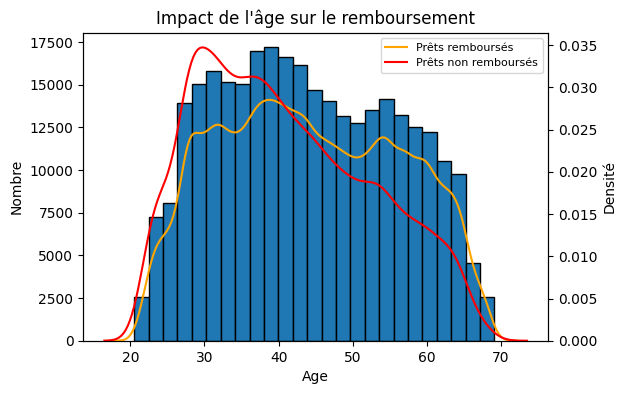

In [46]:
plt.figure(figsize = (6, 4))

figure = plt.figure(figsize=(6,4))
ax1 = plt.subplot2grid(shape=(1, 1), loc=(0, 0), colspan=1, rowspan=1)
ax2 = ax1.twinx()    
ax1.hist(app_temp_df['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
sns.kdeplot(app_temp_df.loc[app_temp_df['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'Prêts remboursés', ax=ax2, color='orange')  
sns.kdeplot(app_temp_df.loc[app_temp_df['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'Prêts non remboursés', ax=ax2, color='red') 

ax1.set_xlabel('Age');
ax1.set_ylabel('Nombre');
ax1.set_title("Impact de l'âge sur le remboursement");
ax2.set_ylabel('Densité'); 
ax2.legend(fontsize=8);

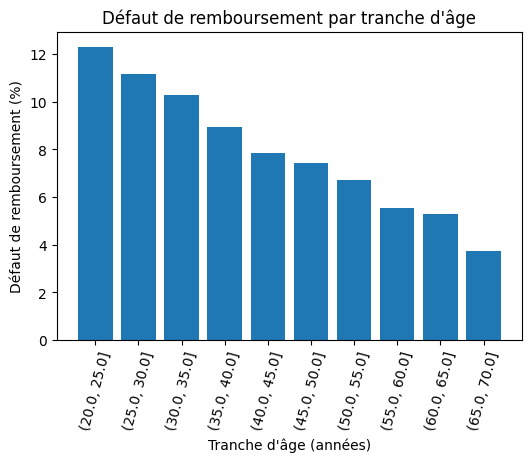

In [47]:
age_data = app_temp_df[['TARGET', 'DAYS_BIRTH']].copy()
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], np.linspace(20, 75, num=12))
age_groups  = age_data.groupby('YEARS_BINNED').mean()

plt.figure(figsize = (6, 4))
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])
plt.xticks(rotation = 75); 
plt.xlabel("Tranche d'âge (années)"); 
plt.ylabel("Défaut de remboursement (%)")
plt.title("Défaut de remboursement par tranche d'âge");

- sources externes

Les 3 variables avec les corrélations négatives sont les sources externes, voyons les corréaltions

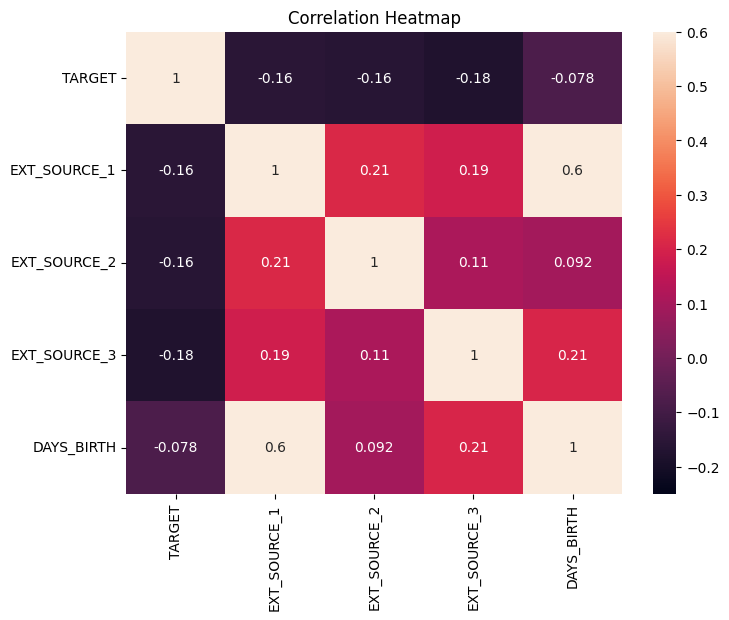

In [48]:
ext_data = app_temp_df[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
plt.figure(figsize = (8, 6))
sns.heatmap(ext_data_corrs, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

- Pairs plot


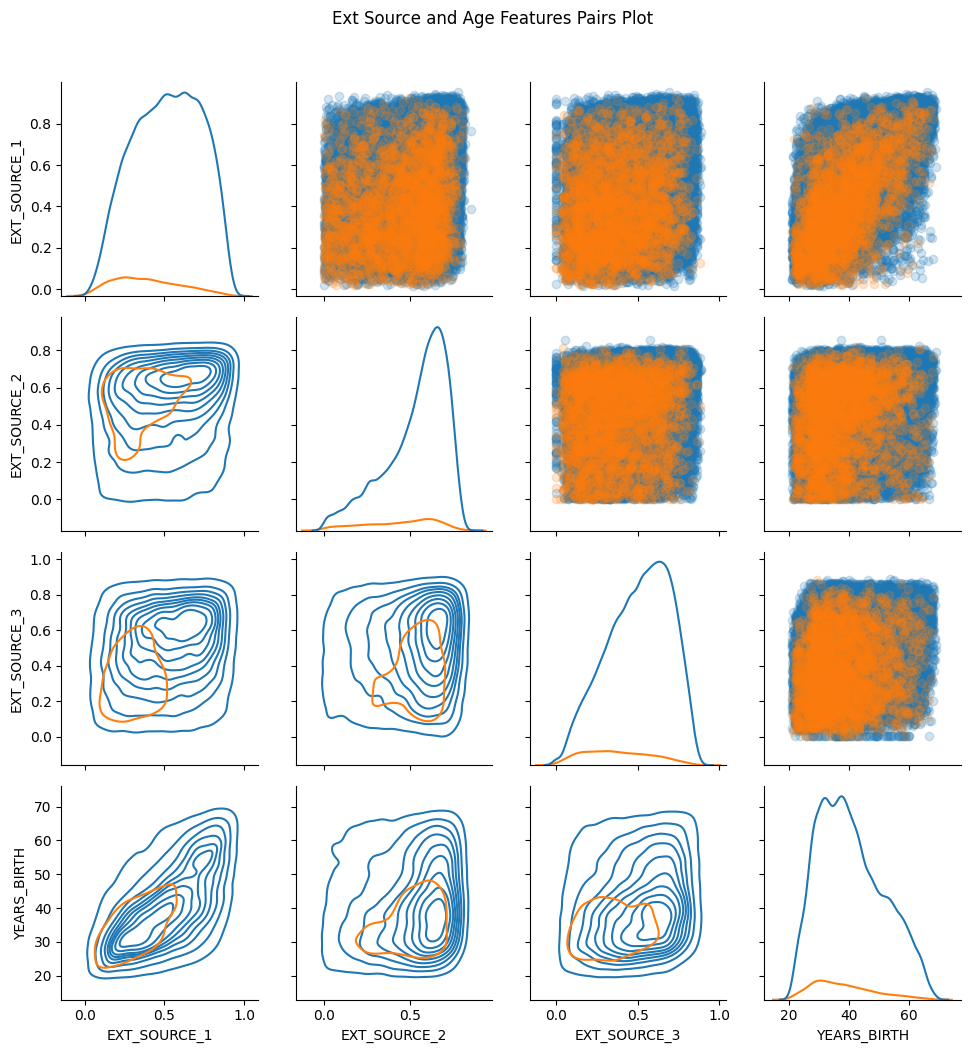

In [49]:
plot_data = ext_data.drop(columns = ['DAYS_BIRTH']).copy()
plot_data['YEARS_BIRTH'] = age_data['YEARS_BIRTH']
plot_data = plot_data.dropna().loc[:100000, :]

def corr_func(x, y, **kwargs):
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.2, .8),
                xycoords=ax.transAxes,
                size = 10)

grid = sns.PairGrid(data=plot_data, 
                    height=2.5, 
                    diag_sharey=False,
                    hue='TARGET', 
                    vars=[x for x in list(plot_data.columns) if x != 'TARGET'])

grid.map_upper(plt.scatter, alpha = 0.2)
grid.map_diag(sns.kdeplot)
grid.map_lower(sns.kdeplot);

plt.suptitle('Ext Source and Age Features Pairs Plot', size = 12, y = 1.05);

In [50]:
del app_temp_df

## <a name="C4"> Feature Engineering</a>

- valeurs manquantes et aberrantes

In [51]:
app_train_df.replace("XNA", np.nan,inplace=True)
app_train_df.replace("XAP", np.nan,inplace=True)
numeric_col_with_nan = list(set(app_train_df.columns[app_train_df.isnull().sum()!=0].tolist()) & set(app_train_df.select_dtypes(include=np.number).columns.tolist()))

for col in numeric_col_with_nan:
    mean_val          = app_train_df[col].mean()
    app_train_df[col] = app_train_df[col].fillna(mean_val) 

object_col_with_nan = list(set(app_train_df.columns[app_train_df.isnull().sum()!=0].tolist()) & set(app_train_df.select_dtypes(include=object).columns.tolist()))
app_train_df = app_train_df.fillna("")

for col in object_col_with_nan:
    most_val = app_train_df[col].value_counts(normalize=False, sort=True, ascending=False, bins=None, dropna=True).index
    if most_val[0]!="":
        most_val=most_val[0]
    else : 
        most_val=most_val[1]
    app_train_df.loc[app_train_df[col]=="", col]=most_val

- encodage des variables catégorielles

In [52]:
print(app_train_df.select_dtypes('object').apply(pd.Series.nunique, axis=0))
le = LabelEncoder()
le_count = 0

for col in app_train_df.columns:
    if app_train_df[col].dtype == 'object':
        # Si le nombre de catégories est <=2
        if len(list(app_train_df[col].unique())) <= 2:
            # Fait la transformation
            print(f"\tTransforme la colonne {col}")
            app_train_df[col] = le.fit_transform(app_train_df[col])
            le_count += 1
            
print(f"{le_count} colonnes transformées avec label encoder.")
app_train_df = pd.get_dummies(app_train_df)
print(f"Le dataframe contient {app_train_df.shape[0]} lignes et {app_train_df.shape[1]} colonnes.")

NAME_CONTRACT_TYPE             2
CODE_GENDER                    2
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             57
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64
	Transforme la colonne NAME_CONTRACT_TYPE
	Transforme la colonne CODE_GENDER
	Transforme la colonne FLAG_OWN_CAR
	Transforme la colonne FLAG_OWN_REALTY
	Transforme la colonne EMERGENCYSTATE_MODE
5 colonnes transformées avec label encoder.
Le dataframe contient 307511 lignes et 274 colonnes.


- Variables métier

- pourcentage de jours employés par rapport à l'âge du client
- pourcentage du montant du crédit par rapport au revenu d'un client
- pourcentage du montant du crédit par individus composant le foyer du client
- pourcentage de la rente du prêt par rapport au revenu d'un client
- pourcentage du montant du crédit remboursé annuellement

In [53]:
app_train_df['DAYS_EMPLOYED_PERCENT'] = app_train_df['DAYS_EMPLOYED'] / app_train_df['DAYS_BIRTH']         
app_train_df['INCOME_CREDIT_PERC'] = app_train_df['AMT_INCOME_TOTAL'] / app_train_df['AMT_CREDIT']       
app_train_df['INCOME_PER_PERSON'] = app_train_df['AMT_INCOME_TOTAL'] / app_train_df['CNT_FAM_MEMBERS']  
app_train_df['ANNUITY_INCOME_PERC'] = app_train_df['AMT_ANNUITY'] / app_train_df['AMT_INCOME_TOTAL']     
app_train_df['PAYMENT_RATE'] = app_train_df['AMT_ANNUITY'] / app_train_df['AMT_CREDIT']           

- Variables polynomiales

In [54]:
poly_target   = app_train_df['TARGET']
poly_features = app_train_df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
poly_transformer = PolynomialFeatures(degree=3)
poly_transformer.fit(poly_features)
poly_features = poly_transformer.transform(poly_features)
print('Polynomial Features shape: ', poly_features.shape)

Polynomial Features shape:  (307511, 35)


In [55]:
poly_fea = poly_transformer.get_feature_names_out(input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])
poly_fea[:15]

array(['1', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH',
       'EXT_SOURCE_1^2', 'EXT_SOURCE_1 EXT_SOURCE_2',
       'EXT_SOURCE_1 EXT_SOURCE_3', 'EXT_SOURCE_1 DAYS_BIRTH',
       'EXT_SOURCE_2^2', 'EXT_SOURCE_2 EXT_SOURCE_3',
       'EXT_SOURCE_2 DAYS_BIRTH', 'EXT_SOURCE_3^2',
       'EXT_SOURCE_3 DAYS_BIRTH', 'DAYS_BIRTH^2'], dtype=object)

In [56]:
poly_features = pd.DataFrame(poly_features, columns=poly_transformer.get_feature_names_out(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']))
poly_features['TARGET'] = poly_target
poly_corrs = poly_features.corr()['TARGET'].sort_values()

In [57]:
del(poly_features['TARGET'])
poly_features['SK_ID_CURR'] = app_train_df['SK_ID_CURR']
app_train_df = app_train_df.merge(poly_features, on = 'SK_ID_CURR', how = 'left')
print('Training data with polynomial features shape: ', app_train_df.shape)


Training data with polynomial features shape:  (307511, 314)


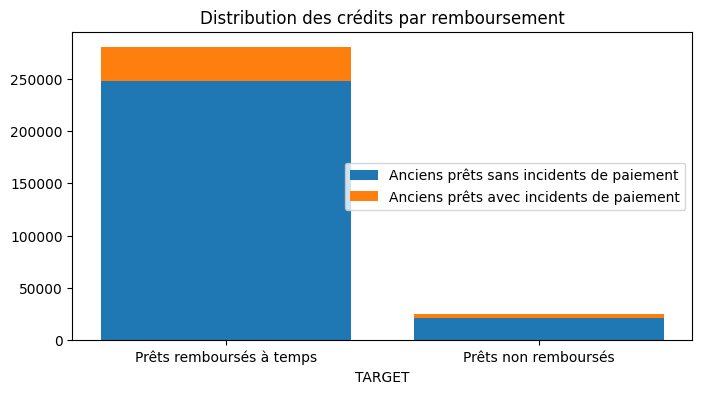

In [58]:
pret_target_0_sans_incidents = app_train_df[(app_train_df['TARGET']==0)&(app_train_df['_SEC_INCIDENTS_CREDITS_ACTIFS']==0)&(app_train_df['_SEC_INCIDENTS_CREDITS_CLOS']==0)].shape[0]
pret_target_0_avec_incidents = app_train_df[(app_train_df['TARGET']==0)&((app_train_df['_SEC_INCIDENTS_CREDITS_ACTIFS']==1)|(app_train_df['_SEC_INCIDENTS_CREDITS_CLOS']==1))].shape[0]
pret_target_1_sans_incidents = app_train_df[(app_train_df['TARGET']==1)&(app_train_df['_SEC_INCIDENTS_CREDITS_ACTIFS']==0)&(app_train_df['_SEC_INCIDENTS_CREDITS_CLOS']==0)].shape[0]
pret_target_1_avec_incidents = app_train_df[(app_train_df['TARGET']==1)&((app_train_df['_SEC_INCIDENTS_CREDITS_ACTIFS']==1)|(app_train_df['_SEC_INCIDENTS_CREDITS_CLOS']==1))].shape[0]
Targets = ["Prêts remboursés à temps", "Prêts non remboursés"]
sans_incidents = [pret_target_0_sans_incidents, pret_target_1_sans_incidents]
avec_incidents = [pret_target_0_avec_incidents, pret_target_1_avec_incidents]

figure = plt.figure(figsize=(8,4))
ax1 = plt.subplot2grid(shape=(1, 1), loc=(0, 0), colspan=1, rowspan=1)
ax1.bar(x = Targets, height = sans_incidents, label = "Anciens prêts sans incidents de paiement")
ax1.bar(x = Targets, height = avec_incidents, label = "Anciens prêts avec incidents de paiement", bottom = sans_incidents)
ax1.set_title('Distribution des crédits par remboursement');
ax1.set_xlabel('TARGET');
ax1.legend()
plt.show()

# PARTIE 2 : Modélisation

## <a name="C4"> Préparation</a>

- Preprocessing via kernel Kaggle 

Créé par ggaragiola mofidié par Levray Dominique
https://www.kaggle.com/code//gwg-hcdr-week8-data-aggregation#Load-Bureau-and-Bureau_Balance-DataSet

In [59]:
data_df = LD0.preprocessing()
print(f"\nInformations sur TARGET")
print(data_df['TARGET'].value_counts())


    

Lecture du fichier csv : data/sources/application_train.csv
	Le fichier data/sources/application_train.csv contient 307511 lignes et 122 colonnes.

Lecture du fichier csv : data/sources/bureau.csv
	Le fichier data/sources/bureau.csv contient 1716428 lignes et 17 colonnes.
	Supprime les individus de bureau.csv pour lesquels l'identifiant SK_ID_CURR n'est pas présent dans application_train.csv
		bureau.csv contient désormais 1465325 au lieu de 1716428 lignes soit -251103 lignes

Lecture du fichier csv : data/sources/bureau_balance.csv
	Le fichier data/sources/bureau_balance.csv contient 27299925 lignes et 3 colonnes.
	Supprime les individus de bureau_balance.csv pour lesquels l'identifiant SK_ID_BUREAU n'est pas présent dans bureau.csv
		bureau_balance.csv contient désormais 14701612 au lieu de 27299925 lignes soit -12598313 lignes

	Préparation de bureau_balance
		bureau_balance : OneHotEncodage de la variable STATUS
		bureau_balance : Compte le nombre d'occurences par STATUS
		b

- Création serveur mlflow

In [60]:
if (sys.platform == "win32"):
    !cmd /C "conda env list"
    !cmd /C "start mlflow ui"


# conda environments:
#
base                     C:\Users\lokma\anaconda3



## <a name="C4"> Création du score métier</a>

Évaluation sur 80% des données initiales :
  - **Random Under-Sampling** : sous-échantillonnage de la classe majoritaire par sélection aléatoire avec ou sans remplacement.
  - **Random Over-Sampling** : suréchantillonnage de la classe minoritaire par sélection aléatoire avec remplacement.
  - **Synthetic Minority Over-sampling** : suréchantillonnage de la classe minoritaire en générant de nouveaux échantillons similaires.
  
- Utilisation de **GridSearchCV** de **scikit-learn** pour déterminer les meilleurs hyperparamètres :
  - Minimisation du coût métier (**best_cv_score**) via les métriques :
    - **Accuracy**
    - **ROC AUC**

- Calcul d'un **score métier** pour chaque évaluation avec les 20% de données restantes.
  
- Maintien d’un seuil de **0,5** pour déterminer la classe 0 ou 1 à partir d'une probabilité.

- Enregistrement des résultats dans **MlFlow**.

- Lancement MLflow

In [61]:
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")
MLFLOW_EXPERIMENT_NAME = "OC_Projet_7"
mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)
mlflow.environment_variables.MLFLOW_HTTP_REQUEST_TIMEOUT = 60*20

**𝑠𝑐𝑜𝑟𝑒 𝑚é𝑡𝑖𝑒𝑟=(3∗𝑇𝑁−10∗𝐹𝑁−𝐹𝑃+𝑇𝑃)/(𝑇𝑁+𝐹𝑁+𝐹𝑃+𝑇𝑃)**


In [62]:
def score_metier(y, y_pred):
    tn = np.where((y_pred == 0) & (y == 0), 3, 0)
    fn = np.where((y_pred == 0) & (y == 1), -10, 0)
    fp = np.where((y_pred == 1) & (y == 0), -1, 0)
    tp = np.where((y_pred == 1) & (y == 1), 0, 0)
    n = len(y)
    return np.sum([tn, fn, tp, fp])/n
scoring = {
    'auc_score'  : make_scorer(roc_auc_score),
    'accuracy'   : make_scorer(accuracy_score)
}

- Division des données

In [63]:
X = data_df.drop(columns="TARGET")
y = data_df['TARGET']
X_train_tbe, X_test, y_train_tbe, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

- Echantillonnage

In [64]:
rus = RandomUnderSampler(random_state=200, replacement=True)
X_rus, y_rus = rus.fit_resample(X_train_tbe, y_train_tbe)
print(f"Nombre de données en Random Under-Sampling : {X_rus.shape[0]} avec la répartition suivante : {y_rus.value_counts()}")

ros = RandomOverSampler(random_state=200)
X_ros, y_ros = ros.fit_resample(X_train_tbe, y_train_tbe)
print(f"\nNombre de données en Random Over-Sampling : {X_ros.shape[0]} avec la répartition suivante : {y_ros.value_counts()}")

smote = SMOTE()
X_smote, y_smote = smote.fit_resample(X_train_tbe, y_train_tbe)
print(f"\nNombre de données en SMOTE : {X_smote.shape[0]} avec la répartition suivante : {y_smote.value_counts()}")


Nombre de données en Random Under-Sampling : 39940 avec la répartition suivante : 0    19970
1    19970
Name: TARGET, dtype: int64

Nombre de données en Random Over-Sampling : 452076 avec la répartition suivante : 0    226038
1    226038
Name: TARGET, dtype: int64

Nombre de données en SMOTE : 452076 avec la répartition suivante : 0    226038
1    226038
Name: TARGET, dtype: int64


- Comparaison des modèles

In [65]:
def testmodel(modelname, modeltype, params, cv, log_model, X_train, y_train, type_donnees):
    print(f"\nTest du model : {modelname} avec {type_donnees}")
    mlflow.sklearn.autolog(max_tuning_runs=None)
    model = modeltype()
    grid_search = GridSearchCV(estimator = model, param_grid = params, scoring = scoring, refit = 'accuracy', cv = cv, n_jobs = -1, verbose = 2)

    with mlflow.start_run() as run:
        mlflow.set_tag("Training", type_donnees)
        grid_search.fit(X_train, y_train)
        display(pd.DataFrame(grid_search.cv_results_).head())
        try:
            y_pred_proba=grid_search.best_estimator_.predict_proba(X_test)             
            y_pred =np.where(y_pred_proba>0.5, 1, 0)[:,1]                       
            y_pred_proba=y_pred_proba[:,1]
        except:  
            y_pred =grid_search.best_estimator_.predict(X_test)
            y_pred_proba=y_pred
        signature = infer_signature(X_train, y_train)               
        model_info = log_model(
            grid_search.best_estimator_,                          
            artifact_path =modelname,                    
            signature =signature,                     
            registered_model_name =modelname,                     
            input_example =X_test,                         
            await_registration_for=60*20                  
        )

        mlflow.log_metric("metier", score_metier(y_test,   y_pred))
        mlflow.log_metric("accuracy", accuracy_score(y_test, y_pred))
        mlflow.log_metric("f1", f1_score(y_test,       y_pred))
        mlflow.log_metric("recall", recall_score(y_test,   y_pred))
        mlflow.log_metric("roc_auc", roc_auc_score(y_test,  y_pred_proba))  
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        somme = tn+fp+fn+tp
        mlflow.log_metric("confusion_matrix_tn", tn/somme)
        mlflow.log_metric("confusion_matrix_fp", fp/somme)
        mlflow.log_metric("confusion_matrix_fn", fn/somme)
        mlflow.log_metric("confusion_matrix_tp", tp/somme)

## <a name="C4"> LightGBM</a>

In [ ]:
params = {'objective' : ['binary'],
          'n_jobs' : [-1],                
          'is_unbalance' : [False],                  
          'num_leaves' : [20, 30, 40],
          'learning_rate' : [0.01, 0.1, 1],
          'n_estimators' : [100, 150],             
          'max_depth' : [6, 15],                 
          'colsample_bytree': [0.8],                  
          'subsample' : [0.7],                  
          'random_state' : [42],                    
}

testmodel('LGBMClassifier', LGBMClassifier, params, cv=3, log_model=mlflow.lightgbm.log_model, X_train=X_rus,   y_train=y_rus,   type_donnees={"imblearn" : "Random Under Sampling"})    
testmodel('LGBMClassifier', LGBMClassifier, params, cv=3, log_model=mlflow.lightgbm.log_model, X_train=X_ros,   y_train=y_ros,   type_donnees={"imblearn" : "Random Over Sampling"})    
testmodel('LGBMClassifier', LGBMClassifier, params, cv=3, log_model=mlflow.lightgbm.log_model, X_train=X_smote, y_train=y_smote, type_donnees={"imblearn" : "SMOTE"})                   

## <a name="C4"> LinearSVC</a>

In [ ]:
params = {'C' : [1],
          'tol' : [0.001, 0.01],
          'loss' : ['squared_hinge'],
          'penalty' : ["l1"],
          'dual' : [False],
          'max_iter' : [2500, 5000]
         }

testmodel('LinearSVC', LinearSVC, params, cv=3, log_model=mlflow.sklearn.log_model, X_train=X_rus,   y_train=y_rus,   type_donnees={"imblearn" : "Random Under Sampling"})   
testmodel('LinearSVC', LinearSVC, params, cv=3, log_model=mlflow.sklearn.log_model, X_train=X_ros,   y_train=y_ros,   type_donnees={"imblearn" : "Random Over Sampling"})    
testmodel('LinearSVC', LinearSVC, params, cv=3, log_model=mlflow.sklearn.log_model, X_train=X_smote, y_train=y_smote, type_donnees={"imblearn" : "SMOTE"})                    

## <a name="C4"> RandomForestClassifier</a>

In [ ]:
params = {
          'n_estimators' : [50, 100, 150],        
          'max_features' : ['sqrt'],               
          'max_depth' : [3, 6],                
          'max_leaf_nodes': [3, 6],               
          'n_jobs' : [-1],                
          'random_state' : [42],                 
         }

testmodel('RandomForestClassifier', RandomForestClassifier, params, cv=3, log_model=mlflow.sklearn.log_model, X_train=X_rus,   y_train=y_rus,   type_donnees={"imblearn" : "Random Under Sampling"})    
testmodel('RandomForestClassifier', RandomForestClassifier, params, cv=3, log_model=mlflow.sklearn.log_model, X_train=X_ros,   y_train=y_ros,   type_donnees={"imblearn" : "Random Over Sampling"})     
testmodel('RandomForestClassifier', RandomForestClassifier, params, cv=3, log_model=mlflow.sklearn.log_model, X_train=X_smote, y_train=y_smote, type_donnees={"imblearn" : "SMOTE"})                   

## <a name="C4"> LogisticRegression</a>

In [ ]:
params = {'penalty' : ['l2'],
          'C' : [1],
          'tol' : [0.001, 0.01],
          'dual' : [False],
          'max_iter' : [50, 100, 150],
          'n_jobs' : [-1],
         }

testmodel('LogisticRegression', LogisticRegression, params, cv=3, log_model=mlflow.sklearn.log_model, X_train=X_rus,   y_train=y_rus,   type_donnees={"imblearn" : "Random Under Sampling"})   
testmodel('LogisticRegression', LogisticRegression, params, cv=3, log_model=mlflow.sklearn.log_model, X_train=X_ros,   y_train=y_ros,   type_donnees={"imblearn" : "Random Over Sampling"})    
testmodel('LogisticRegression', LogisticRegression, params, cv=3, log_model=mlflow.sklearn.log_model, X_train=X_smote, y_train=y_smote, type_donnees={"imblearn" : "SMOTE"})                   

## <a name="C4"> Feature Importance</a>

- Création de fonctions utiles

In [49]:
def try_conv(valeur):
    if valeur=="False":     
        return False                   
    elif valeur=="True":    
        return True                   
    else:
        try:    
            return int(valeur)         
        except:
            try:                        
                return float(valeur)    
            except:                     
                return valeur          

def get_best_modele(df, best_params):
    if df.iloc[0]["params.estimator"].startswith("LGBMClassifier"):
        model = LGBMClassifier(**best_params)
    elif df.iloc[0]["params.estimator"].startswith("LogisticRegression"):
        model = LogisticRegression(**best_params)
    elif df.iloc[0]["params.estimator"].startswith("LinearSVC"):
        model = LinearSVC(**best_params)
    elif df.iloc[0]["params.estimator"].startswith("RandomForestClassifier"):
        model = RandomForestClassifier(**best_params)
    else:
        print("Erreur")
        
    return model

## <a name="C4"> Selection du meilleur modèle</a>

In [ ]:
current_experiment = dict(mlflow.get_experiment_by_name(MLFLOW_EXPERIMENT_NAME))
experiment_id = current_experiment['experiment_id']
df = mlflow.search_runs([experiment_id]).sort_values("metrics.metier", ascending=False)  
print(f"Meilleur model :"
      f"\n run_id = {df.iloc[0]["run_id"]}"
      f"\n estimator = {df.iloc[0]["params.estimator"]}"
      f"\n jeu de données = {df.iloc[0]["tags.Training"]}"
      f"\n score_metier = {df.iloc[0]["metrics.metier"]}"
      f"\n best_cv_score = {df.iloc[0]["metrics.best_cv_score"]}"
      f"\n accuracy_score (train/test) = {df.iloc[0]["metrics.training_accuracy_score"]}/{df.iloc[0]["metrics.accuracy"]}"
      f"\n roc_auc (train/test) = {df.iloc[0]["metrics.training_roc_auc"]}/{df.iloc[0]["metrics.roc_auc"]}"
     )
run_id = df.iloc[0]["run_id"]   
client = MlflowClient()             
data   = client.get_run(run_id).data  
best_params    = {k[len("best_"):]: try_conv(v) for k, v in data.params.items() if k.startswith("best_")}
print("\nMeilleurs hypertparamètres :")
pprint.pprint(best_params)
print("\nMetriques associés à ce test :")
pprint.pprint(data.metrics)
print("\nTags associés à ce test :")
tags = {k: v for k, v in data.tags.items() if not k.startswith("mlflow.")}     
pprint.pprint(tags)
print("\nArtifacts associés à ce test :")
artifacts = [f.path for f in client.list_artifacts(run_id, "model")]
pprint.pprint(artifacts)

In [ ]:
model =get_best_modele(df, best_params)
print(f"Entrainement du modele avec le jeu de données {df.iloc[0]["tags.Training"]}")
if df.iloc[0]["tags.Training"].find("SMOTE")>0:
    model.fit(X_smote, y_smote)
elif df.iloc[0]["tags.Training"].find("Random Over Sampling")>0:
    model.fit(X_ros, y_ros)
elif df.iloc[0]["tags.Training"].find("Random Under Sampling")>0:
    model.fit(X_rus, y_rus)
else:
    print("Erreur")
model

In [ ]:
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred       = np.where(y_pred_proba>=0.5, 1, 0)  
print(f"\nScores de référence avec le meilleur modèle :"
      f"\n\tL'accuracy_score avec ce seuil est de {accuracy_score(y_test, y_pred)*100:.3f}%"
      f"\n\tLe roc_auc_score avec ce seuil est de {roc_auc_score(y_test, y_pred)*100:.3f}%"
      f"\n\tLe score métier est de {score_metier(y_test, y_pred):.3f}")

## <a name="C4"> Finalisation du jeu de données</a>

- Détermination du feature Importance

In [ ]:
WANTED_IMPORTANCE = 90
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_, X.columns), reverse=True), columns=['Value', 'Feature'])
feature_imp["pct"] = (feature_imp.Value / sum(feature_imp.Value)) * 100
feature_imp["pct_cum"] = np.cumsum(feature_imp["pct"])
feature_selection = feature_imp[feature_imp["pct_cum"]<=WANTED_IMPORTANCE]['Feature'].to_list()
NEEDED_FEATURES = ['SK_ID_CURR', 'FLAG_OWN_REALTY', 'FLAG_OWN_CAR', 'OWN_CAR_AGE', 'NAME_INCOME_TYPE_Working', 'DAYS_EMPLOYED', 
                   'AMT_GOODS_PRICE', 'AMT_CREDIT', 'EXT_SOURCE_1_x', 'EXT_SOURCE_2_x', 'EXT_SOURCE_3_x']
for feat in NEEDED_FEATURES:
    if feat not in feature_selection:
        feature_selection.append(feat)
print(f"On conserve {len(feature_selection)} features pour atteindre {WANTED_IMPORTANCE:.1f}% d'importance conservée")
new_X_test = X_test[feature_selection]
part_test_df=pd.concat([new_X_test, y_test], axis=1)
part_test_df=part_test_df.sample(frac=0.5)  
LD0.write_csv_zip_file(ZIP_TEST_DATA_FILENAME, part_test_df)
del part_test_df

- Ré-instanciation du meilleur estimateur avec les meilleurs parametres

In [ ]:
model =get_best_modele(df, best_params)
if df.iloc[0]["tags.Training"].find("SMOTE")>0:
    model.fit(X_smote[feature_selection], y_smote)
    signature = infer_signature(X_smote[feature_selection], y_smote) 
elif df.iloc[0]["tags.Training"].find("Random Over Sampling")>0:
    model.fit(X_ros[feature_selection], y_ros)
    signature = infer_signature(X_ros[feature_selection], y_ros) 
elif df.iloc[0]["tags.Training"].find("Random Under Sampling")>0:
    model.fit(X_rus[feature_selection], y_rus)
    signature = infer_signature(X_rus[feature_selection], y_rus) 
else:
    print("Erreur")

- Calcul des scores après réduction des dimensions

In [ ]:
y_pred_proba = model.predict_proba(new_X_test)[:, 1]
y_pred = np.where(y_pred_proba>=0.5, 1, 0)  
print(f"\nNouveaux scores obtenu avec le jeu de données final :"
      f"\n\tL'accuracy_score avec ce seuil est de {accuracy_score(y_test, y_pred)*100:.3f}%"
      f"\n\tLe roc_auc_score avec ce seuil est de {roc_auc_score(y_test, y_pred)*100:.3f}%"
      f"\n\tLe score métier est de {score_metier(y_test, y_pred):.3f}")

- Sauvegarde du modèle

In [56]:
if os.path.exists(MLFLOW_MODEL_FOLDER):
    if (sys.platform == "win32"):
        os.system(f"RMDIR {MLFLOW_MODEL_FOLDER_WIN} /s /q")
    else:
        os.system(f"rm -rf {MLFLOW_MODEL_FOLDER}")
mlflow.sklearn.save_model(make_pipeline(model), MLFLOW_MODEL_FOLDER, signature=signature)

## <a name="C4"> Seuil de décision</a>

**Objectif :** Trouver le meilleur seuil de décision pour :
  - Minimiser les **faux négatifs** (perte en capital)
  - Minimiser les **faux positifs** (manque à gagner en marge)
  - Maximiser les **vrais positifs** (gains en marge)
  - Maximiser les **vrais négatifs** (éviter pertes en capital)

- **Précision :** Ratio des prédictions positives correctes sur le total des prédictions positives.
  - **Formule** : Précision = TP / (TP + FP)

- **Rappel :** Ratio des vraies prédictions positives sur le total des données positives.
  - **Formule** : Rappel = TP / (TP + FN)

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
plt.plot(recall, precision)
plt.xlabel('Rappel')
plt.ylabel('Précision')
plt.title('Courbe PR')

best_threshold = 0.27
plt.axline((0,0), (1,1))
plt.axline((best_threshold,0), (best_threshold,1))
plt.show()

In [ ]:
print("\nValeurs réelles :\n", y_test.value_counts())
y_pred = np.where(y_pred_proba>=best_threshold, 1, 0) 
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))
disp.plot()
plt.show()

y_pred_df=pd.DataFrame(y_pred, columns=['TARGET'])
print(f"Le seuil de probabilité idéal pour minimiser le recall est de {best_threshold}")
print("Valeurs prédites avec ce nouveau seuil :\n", y_pred_df.value_counts())
print(f"\nAvec le seuil idéal de {best_threshold} :"
      f"\n\tL'accuracy_score avec ce seuil est de {accuracy_score(y_test, y_pred)*100:.3f}%"
      f"\n\tLe roc_auc_score avec ce seuil est de {roc_auc_score(y_test, y_pred)*100:.3f}%"
      f"\n\tLe score métier est de {score_metier(y_test, y_pred):.3f}")

## <a name="C4"> Analyse des feature importance</a>

- Features importance globales

In [ ]:
explainer = shap.TreeExplainer(model)  
shap_values = explainer(new_X_test)
nbr_colonnes   = 20
shap.summary_plot(shap_values, new_X_test, max_display=nbr_colonnes) 

In [ ]:
feature_names = shap_values.feature_names
shap_df = pd.DataFrame(shap_values.values, columns=feature_names)
vals = np.abs(shap_df.values).mean(0)
shap_importance = pd.DataFrame(list(zip(feature_names, vals)), columns=['col_name', 'feature_importance_vals'])
shap_importance.sort_values(by=['feature_importance_vals'], ascending=False, inplace=True)
shap_importance.head(30)

- Features importances locales

In [ ]:
X_test_sorted = new_X_test.reset_index(drop=True)
sample = y_pred_df[y_pred_df['TARGET']==1]     
index_credit=sample.index[0]                  
print(f"Affichage des informations détaillées pour le crédit n°{index_credit} avec TARGET={y_pred_df.iloc[index_credit]['TARGET']}")
print(f"\nExplication pour ce crédit : Probabilité={y_pred_proba[index_credit]} - Acceptation={y_pred_df.iloc[index_credit]['TARGET']} - Seuil={best_threshold} - Base value={explainer.expected_value}")
shap.force_plot(explainer.expected_value, shap_values.values[index_credit, :], X_test_sorted.iloc[index_credit, :], matplotlib=True, show=True)  


In [ ]:
sample = y_pred_df[y_pred_df['TARGET']==0]     
index_credit=sample.index[0]                
print(f"Affichage des informations détaillées pour le crédit n°{index_credit} avec TARGET={y_pred_df.iloc[index_credit]['TARGET']}")
print(f"\nExplication pour ce crédit : Probabilité={y_pred_proba[index_credit]} - Acceptation={y_pred_df.iloc[index_credit]['TARGET']} - Seuil={best_threshold} - Base value={explainer.expected_value}")
shap.force_plot(explainer.expected_value, shap_values.values[index_credit, :], X_test_sorted.iloc[index_credit, :], matplotlib=True, show=True, text_rotation=45)    

## <a name="C4"> Data Drift</a>

- Création d'un rapport html

In [ ]:
train_df = LD0.read_csv_file("data/sources/application_train.csv")
test_df = LD0.read_csv_file('data/sources/application_test.csv')

feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
print("\nFiltrage des colonnes")
train_df=train_df.filter(feats)
print(f"\ttrain_df={train_df.shape}")
test_df =test_df.filter(feats)
print(f"\ttest_df ={test_df.shape}")

column_mapping = ColumnMapping()
column_mapping.numerical_features   = train_df.select_dtypes(exclude=['object']).columns.tolist()   
column_mapping.categorical_features = train_df.select_dtypes(include=['object']).columns.tolist()  
report = Report(metrics=[DataDriftPreset(), ])                                                      
report.run(column_mapping = column_mapping, reference_data=train_df, current_data=test_df)         
report.save_html(DRIFT_FILENAME)                                                                  


## <a name="C4"> Entrainement LGBM supplémentaires </a>

- LGBM (paramètre is_unbalance)

In [66]:
params = {'objective' : ['binary'],
          'n_jobs' : [-1],                
          'is_unbalance' : [True],                  
          'num_leaves' : [20, 30, 40],
          'learning_rate' : [0.01, 0.1, 1],
          'n_estimators' : [100, 150],             
          'max_depth' : [6, 15],                 
          'colsample_bytree': [0.8],                  
          'subsample' : [0.7],                  
          'random_state' : [42],                    
}

testmodel('LGBMClassifier', LGBMClassifier, params, cv=3, log_model=mlflow.lightgbm.log_model, X_train=X_train_tbe,   y_train=y_train_tbe,   type_donnees=None)                   

2024/09/29 17:52:36 WARNING mlflow.utils.autologging_utils: MLflow sklearn autologging is known to be compatible with 0.24.1 <= scikit-learn <= 1.5.1, but the installed version is 1.5.2. If you encounter errors during autologging, try upgrading / downgrading scikit-learn to a compatible version, or try upgrading MLflow.



Test du model : LGBMClassifier avec None


2024/09/29 17:53:16 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\lokma\Desktop\Projet_7\.venv\Lib\site-packages\mlflow\types\utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


Fitting 3 folds for each of 36 candidates, totalling 108 fits
[LightGBM] [Info] Number of positive: 19970, number of negative: 226038
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.278854 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 28343
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 304
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081176 -> initscore=-2.426472
[LightGBM] [Info] Start training from score -2.426472


2024/09/29 17:59:07 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\lokma\Desktop\Projet_7\.venv\Lib\site-packages\mlflow\types\utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2024/09/29 17:59:16 INFO mlflow.tracking._tracking_service.client: 🏃 View run merciful-asp-202 at: http://127.0.0.1:5000/#/experiments/8774797781

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_is_unbalance,param_learning_rate,param_max_depth,param_n_estimators,param_n_jobs,param_num_leaves,param_objective,param_random_state,param_subsample,params,split0_test_auc_score,split1_test_auc_score,split2_test_auc_score,mean_test_auc_score,std_test_auc_score,rank_test_auc_score,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
0,39.582,4.019,0.374,0.035,0.800,True,0.010,6,100,-1,20,binary,42,0.700,"{'colsample_bytree': 0.8, 'is_unbala...",0.586,0.584,0.590,0.587,0.003,35,0.889,0.890,0.890,0.890,0.001,5
1,55.232,6.261,0.419,0.039,0.800,True,0.010,6,100,-1,30,binary,42,0.700,"{'colsample_bytree': 0.8, 'is_unbala...",0.591,0.585,0.592,0.589,0.003,33,0.889,0.891,0.890,0.890,0.001,2
2,63.760,7.808,0.382,0.023,0.800,True,0.010,6,100,-1,40,binary,42,0.700,"{'colsample_bytree': 0.8, 'is_unbala...",0.594,0.584,0.592,0.590,0.004,32,0.890,0.892,0.891,0.891,0.001,1
3,49.891,0.089,0.513,0.021,0.800,True,0.010,6,150,-1,20,binary,42,0.700,"{'colsample_bytree': 0.8, 'is_unbala...",0.658,0.656,0.659,0.658,0.001,18,0.815,0.816,0.817,0.816,0.001,10
4,70.205,0.369,0.376,0.005,0.800,True,0.010,6,150,-1,30,binary,42,0.700,"{'colsample_bytree': 0.8, 'is_unbala...",0.662,0.657,0.660,0.659,0.002,15,0.819,0.818,0.820,0.819,0.001,8


c:\Users\lokma\Desktop\Projet_7\.venv\Lib\site-packages\mlflow\types\utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'LGBMClassifier' already exists. Creating a new version of this model...
2024/09/29 18:00:21 INFO mlflow.store.model_registry.abstract_store: Waiting up to 1200 seconds for model version to finish creation. Model na

- LGBM (paramètre scale_pos_weight)

In [67]:
params = {'objective' : ['binary'],
          'n_jobs' : [-1],                
          'scale_pos_weight' : [11.39],                  
          'num_leaves' : [20, 30, 40],
          'learning_rate' : [0.01, 0.1, 1],
          'n_estimators' : [100, 150],             
          'max_depth' : [6, 15],                 
          'colsample_bytree': [0.8],                  
          'subsample' : [0.7],                  
          'random_state' : [42],                    
}

testmodel('LGBMClassifier', LGBMClassifier, params, cv=3, log_model=mlflow.lightgbm.log_model, X_train=X_train_tbe,   y_train=y_train_tbe,   type_donnees=None)     

2024/09/29 18:04:42 WARNING mlflow.utils.autologging_utils: MLflow sklearn autologging is known to be compatible with 0.24.1 <= scikit-learn <= 1.5.1, but the installed version is 1.5.2. If you encounter errors during autologging, try upgrading / downgrading scikit-learn to a compatible version, or try upgrading MLflow.



Test du model : LGBMClassifier avec None


2024/09/29 18:05:23 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\lokma\Desktop\Projet_7\.venv\Lib\site-packages\mlflow\types\utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


Fitting 3 folds for each of 36 candidates, totalling 108 fits
[LightGBM] [Info] Number of positive: 19970, number of negative: 226038
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.051402 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 28343
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 304
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081176 -> initscore=-2.426472
[LightGBM] [Info] Start training from score -2.426472


2024/09/29 18:13:58 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\lokma\Desktop\Projet_7\.venv\Lib\site-packages\mlflow\types\utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


2024/09/29 18:14:04 INFO mlflow.tracking._tracking_service.client: 🏃 View run bald-wasp-296 at: http://127.0.0.1:5000/#/experiments/877479778163840782/runs/e71a2136dd91414398f59ea4f69c1381.
2024/09/29 18:14:04 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/877479778163840782.
2024/09/29 18:14:04 INFO mlflow.tracking._tracking_service.client: 🏃 View run resilient-mule-760 at: http://127.0.0.1:5000/#/experiments/877479778163840782/runs/35b9ff92539d4243ae8337915e9d198e.
2024/09/29 18:14:04 INFO mlflow.tracking._tracking_service.client: 🏃 View run receptive-mink-936 at: http://127.0.0.1:5000/#/experiments/877479778163840782/runs/9bd790c0ffed4c668cdff1a466a5e499.
2024/09/29 18:14:04 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/877479778163840782.
2024/09/29 18:14:04 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/87747

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_learning_rate,param_max_depth,param_n_estimators,param_n_jobs,param_num_leaves,param_objective,param_random_state,param_scale_pos_weight,param_subsample,params,split0_test_auc_score,split1_test_auc_score,split2_test_auc_score,mean_test_auc_score,std_test_auc_score,rank_test_auc_score,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
0,40.006,0.432,0.425,0.039,0.800,0.010,6,100,-1,20,binary,42,11.390,0.700,"{'colsample_bytree': 0.8, 'learning_...",0.587,0.585,0.591,0.587,0.002,35,0.888,0.890,0.889,0.889,0.001,5
1,58.691,5.982,0.477,0.091,0.800,0.010,6,100,-1,30,binary,42,11.390,0.700,"{'colsample_bytree': 0.8, 'learning_...",0.592,0.586,0.592,0.590,0.003,33,0.889,0.890,0.889,0.889,0.001,2
2,64.849,0.099,0.377,0.018,0.800,0.010,6,100,-1,40,binary,42,11.390,0.700,"{'colsample_bytree': 0.8, 'learning_...",0.595,0.586,0.594,0.591,0.004,31,0.890,0.891,0.891,0.890,0.001,1
3,68.731,7.561,0.454,0.033,0.800,0.010,6,150,-1,20,binary,42,11.390,0.700,"{'colsample_bytree': 0.8, 'learning_...",0.659,0.657,0.659,0.658,0.001,18,0.814,0.814,0.817,0.815,0.001,10
4,88.479,13.048,0.434,0.016,0.800,0.010,6,150,-1,30,binary,42,11.390,0.700,"{'colsample_bytree': 0.8, 'learning_...",0.662,0.658,0.660,0.660,0.002,15,0.818,0.817,0.819,0.818,0.001,8


c:\Users\lokma\Desktop\Projet_7\.venv\Lib\site-packages\mlflow\types\utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'LGBMClassifier' already exists. Creating a new version of this model...
2024/09/29 18:15:11 INFO mlflow.store.model_registry.abstract_store: Waiting up to 1200 seconds for model version to finish creation. Model na